# GEMS NLCD Usage Example
## Set up an HTTP client using Python's request library
We use a Session object to store our API key and automatically include it in the header for each request.

Note that we have a `api_key.py` file in the Exchange-Notebooks directory. The file contains only the below line.
```
api_key = 'SECRET'
```

In [1]:
from requests import Session
import pandas as pd
pd.options.display.max_colwidth = 500
from os import environ as os_env
import rasterio
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import sys
sys.path.append('..')
from api_key import key as api_key

s = Session()
s.headers.update({'apikey': api_key})
landcover_url = "https://exchange-1.gems.msi.umn.edu/landcover/v2"

## Get description for available layers

NLCD allows to distinguish the following land cover classes:

| Class | Value |
| --------------- | --------------- |
| Open Water | 11 |
| Perennial Ice/Snow | 12 |
| Developed, Open Space | 21 |
| Developed, Low Intensity | 22 |
| Developed, Medium Intensity | 23 |
| Developed High Intensity | 24 |
| Barren Land (Rock/Sand/Clay) | 31 |
| Deciduous Forest | 41 |
| Evergreen Forest | 42 |
| Mixed Forest | 43 | 
| Shrub/Scrub | 52 |
| Grassland/Herbaceous | 71 |
| Pasture/Hay | 81 |
| Cultivated Crops | 82 |
| Woody Wetlands | 90 |
| Emergent Herbaceous Wetlands | 95 |  

In [2]:
res = s.get(landcover_url+"/nlcd/layer")
layers = pd.json_normalize(res.json())
layers

,name,units,description,discrete,id
0,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",True,250


## Access and vizualize raster data

Example below illustrates one of the fastest-growing metropolitan areas in the US - the Villages, a retirement community in Florida.

### List available objects within the area of interest

In [3]:
area_of_interest = "-82.05,28.82,-81.92,28.99"
params = {
    "bbox": area_of_interest
}
res = s.get(landcover_url+"/nlcd/object/search", params=params)

df = pd.json_normalize(res.json())
df

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187278,5,"[{'begin': '2011', 'end': '2012'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250
1,187276,5,"[{'begin': '2006', 'end': '2007'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250
2,187279,5,"[{'begin': '2013', 'end': '2014'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250
3,187274,5,"[{'begin': '2001', 'end': '2002'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250
4,187280,5,"[{'begin': '2016', 'end': '2017'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250
5,187275,5,"[{'begin': '2004', 'end': '2005'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250
6,187281,5,"[{'begin': '2019', 'end': '2020'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250
7,187277,5,"[{'begin': '2008', 'end': '2009'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250


### Vizualize raster data for years of interest

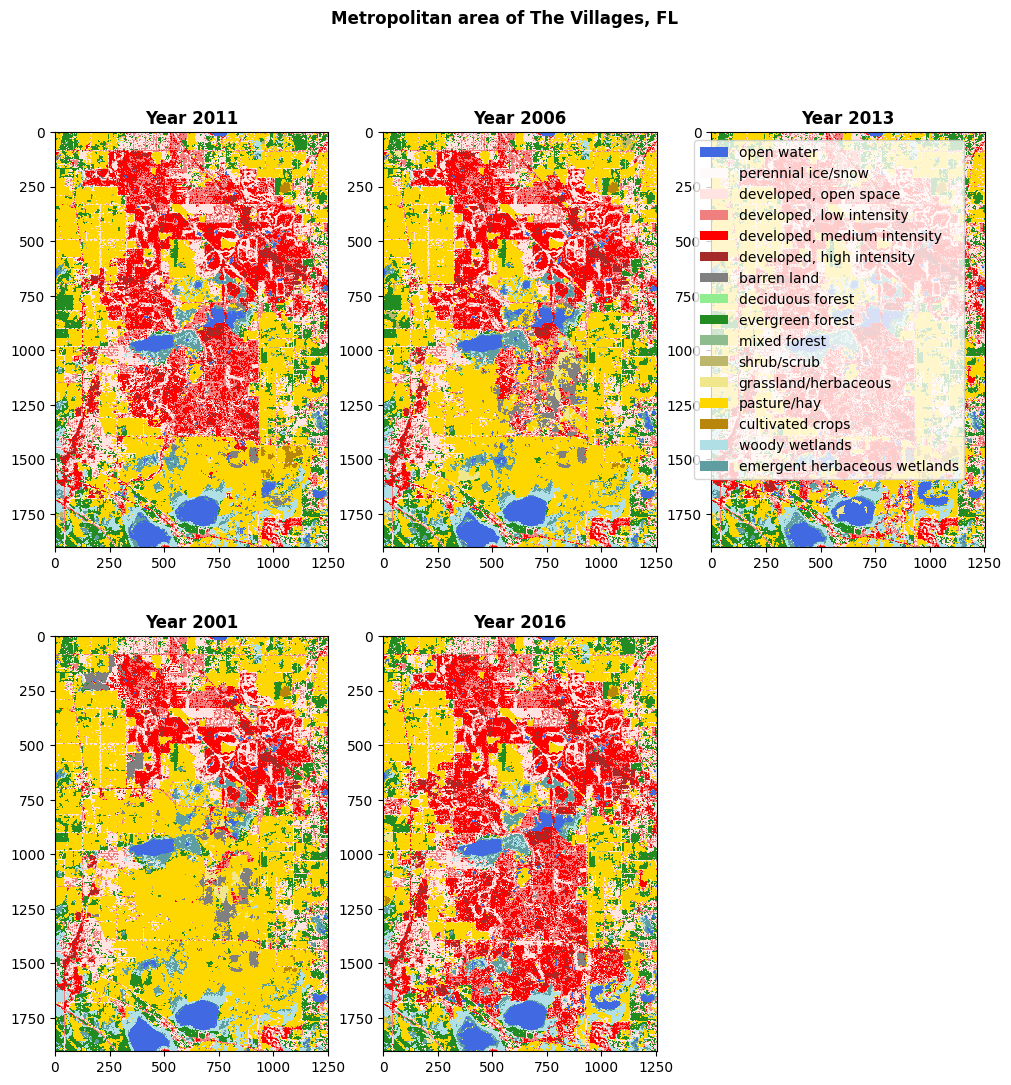

In [4]:
object_ids_of_interest = [187278, 187276, 187279, 187274, 187280]

width = 5
height = 5
rows = 2
cols = 3
axes = []

fig = plt.figure(figsize=(12,12))

clrs = ["royalblue", "snow", "mistyrose", "lightcoral", "red", "brown", "grey",
          "lightgreen", "forestgreen", "darkseagreen", "darkkhaki", "khaki", 
          "gold", "darkgoldenrod", "powderblue", "cadetblue"]

labels = ["open water", "perennial ice/snow", "developed, open space", "developed, low intensity", 
         "developed, medium intensity", "developed, high intensity", "barren land", 
         "deciduous forest", "evergreen forest", "mixed forest", "shrub/scrub", "grassland/herbaceous", 
         "pasture/hay", "cultivated crops", "woody wetlands", "emergent herbaceous wetlands"]

cmap = ListedColormap(clrs)
norm = colors.BoundaryNorm([11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95], 15)


for index, object_id in zip(range(rows*cols), object_ids_of_interest):
    res = s.get(landcover_url + f"/nlcd/object/{object_id}")
    year = res.json()["t_ranges"][0]['begin']
    res = s.get(landcover_url + f"/nlcd/object/{object_id}/raster", params=params)
    raster = res.content
    with rasterio.MemoryFile(raster) as memfile:
        with memfile.open() as dataset:
            data = dataset.read(1)
            values = np.unique(data.ravel())
            axes.append( fig.add_subplot(rows, cols, index+1))
            subplot_title=(f"Year {year}")
            axes[-1].set_title(subplot_title, weight="bold")
            plt.imshow(data, interpolation="none", cmap=cmap, norm=norm)

c = [ mpatches.Patch(facecolor=clrs[i]) for i in range(len(labels))]
plt.legend(c, labels, bbox_to_anchor=(2.15, 2.21))

plt.suptitle("Metropolitan area of The Villages, FL", weight="bold")
plt.show()

##  Obtain raster value count

### Get value count for land cover classes of interest

In [5]:
classes = {
    22: "Developed, low intensity",
    23: "Developed, medium intensity",
    24: "Developed, high intensity"
}
for index,row in df.iterrows():
    res = s.get(landcover_url + "/nlcd/object/{}/valuecount".format(row["id"]), params=params)
    for key, value in classes.items():
        for item in res.json():
            if item["value"] == key:
                df.loc[index,"{} count".format(value)] = item["count"]
df

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id,"Developed, low intensity count","Developed, medium intensity count","Developed, high intensity count"
0,187278,5,"[{'begin': '2011', 'end': '2012'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,348291.0,375030.0,56903.0
1,187276,5,"[{'begin': '2006', 'end': '2007'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,280261.0,274077.0,39821.0
2,187279,5,"[{'begin': '2013', 'end': '2014'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,388291.0,427952.0,70283.0
3,187274,5,"[{'begin': '2001', 'end': '2002'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,220674.0,196121.0,25851.0
4,187280,5,"[{'begin': '2016', 'end': '2017'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,407309.0,481236.0,78183.0
5,187275,5,"[{'begin': '2004', 'end': '2005'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,271032.0,250647.0,34597.0
6,187281,5,"[{'begin': '2019', 'end': '2020'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,408236.0,492793.0,83416.0
7,187277,5,"[{'begin': '2008', 'end': '2009'}]",None,None,NLCD-LandCover,unitless,"Nationwide data on land cover with a 16-class legend, for more information see https://www.mrlc.gov/data",250,339796.0,330007.0,48864.0


### Plot temporal trends in land cover change

Text(0.5, 1.0, 'Developed area growth, The Villages, FL')

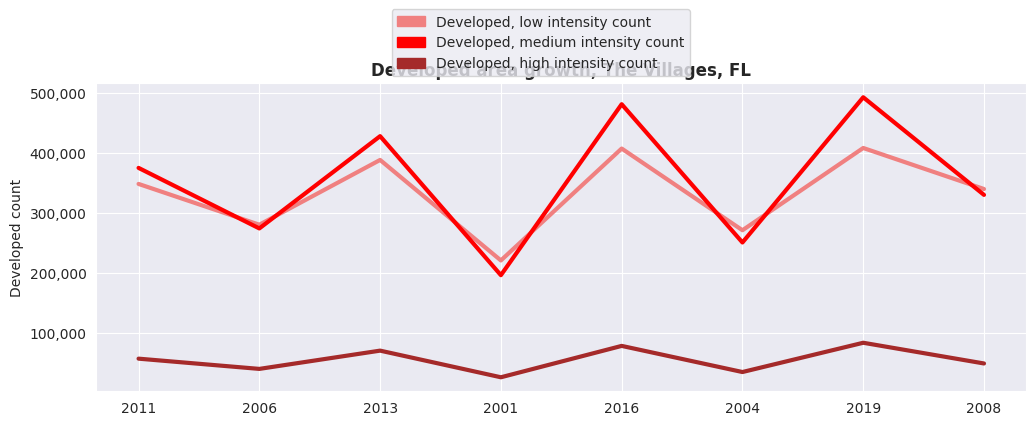

In [6]:
clrs = {
    "Developed, low intensity count": "lightcoral",
    "Developed, medium intensity count": "red",
    "Developed, high intensity count": "brown"
}

sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize=(12,4))
df['year'] = df.t_ranges.apply(lambda x: x[0]['begin'])
ax.plot(df.year, df["Developed, low intensity count"], linewidth=3, color= clrs["Developed, low intensity count"])
ax.plot(df.year, df["Developed, medium intensity count"], linewidth=3, color= clrs["Developed, medium intensity count"])
ax.plot(df.year, df["Developed, high intensity count"], linewidth=3, color= clrs["Developed, high intensity count"])
ax.set_ylabel("Developed count")
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(df["year"])
dev_l = mpatches.Patch(color=clrs["Developed, low intensity count"], label="Developed, low intensity count")
dev_m = mpatches.Patch(color=clrs["Developed, medium intensity count"], label="Developed, medium intensity count")
dev_h = mpatches.Patch(color=clrs["Developed, high intensity count"], label="Developed, high intensity count")
ax.legend(handles=[dev_l,dev_m,dev_h], bbox_to_anchor=(0.31, 1))
ax.set_title("Developed area growth, The Villages, FL", weight="bold")

## Sample Point Data

The following example illustrates how to get data values for points from their geographic coordinates.

In [7]:
points = {
    "name":["point1", "point2", "point3", "point4"], 
    "lat":[45.18, 42.99, 29.26, 35.7], 
    "lon":[-115.5, -112.7, -98.54, -78.36]
}

df = pd.DataFrame(points)

for i in [187278, 187276, 187279, 187274, 187280]:
    for index,row in df.iterrows():
        params = {
            "lat" : row["lat"],
            "lon" : row["lon"]
        }
        res = s.get(landcover_url + f"/nlcd/object/{i}")
        year = '-'.join([yr for _, yr in res.json()["t_ranges"][0].items()])
        res = s.get(landcover_url + f"/nlcd/object/{i}/point", params=params)
        df.loc[index, str(year)] = res.json()["value"]
df

,name,lat,lon,2011-2012,2006-2007,2013-2014,2001-2002,2016-2017
0,point1,45.18,-115.50,71.0,42.0,71.0,42.0,71.0
1,point2,42.99,-112.70,11.0,31.0,31.0,31.0,31.0
2,point3,29.26,-98.54,23.0,23.0,23.0,52.0,23.0
3,point4,35.70,-78.36,81.0,81.0,81.0,81.0,81.0
